In [21]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()  
plt.rcParams['axes.unicode_minus']=False

[*********************100%***********************]  1 of 1 completed
download AMZN data: 1550
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-02  58.599998  59.500000  58.525501  59.450500  59.450500  53890000
2018-01-03  59.415001  60.274502  59.415001  60.209999  60.209999  62176000
2018-01-04  60.250000  60.793499  60.233002  60.479500  60.479500  60442000
2018-01-05  60.875500  61.457001  60.500000  61.457001  61.457001  70894000
2018-01-08  61.799999  62.653999  61.601501  62.343498  62.343498  85590000


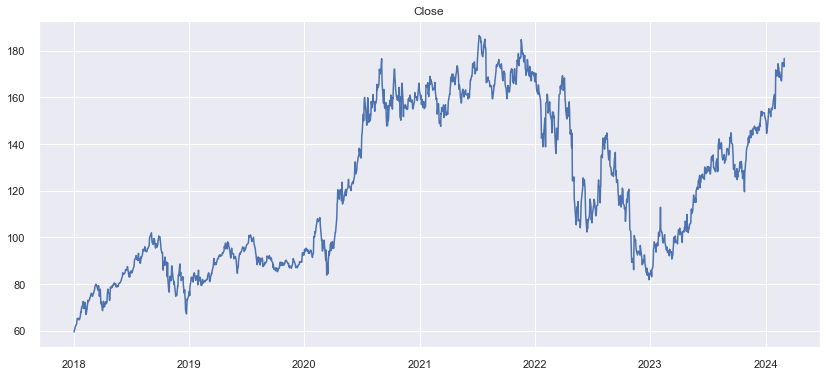

In [22]:
# get data
import yfinance as yf
symbol = "AMZN"
tk = yf.Ticker(symbol)
data = yf.download(symbol,start="2018-01-01", end="2024-03-01")
print(f"download {symbol} data: {len(data)}")
print(data.head())
plt.figure(figsize=(14,6))
plt.title('Close')
plt.plot(data['Adj Close'])

In [23]:
import numpy as np
import pandas as pd
import datetime, os, random
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf                                                       
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator       

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

def set_seeds(seed=123): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
results_path = Path('results', 'lstm_time_series'+symbol)
if not results_path.exists():
    results_path.mkdir(parents=True)

In [24]:
train_data, test_data = train_test_split(data, train_size=0.75, test_size=0.25, shuffle=False)

print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

features = ['Volume'] #'Open', 'High', 'Low','Volume'
features = []
target = 'Adj Close'

if len(features) > 0:
    X_scaler = MinMaxScaler()
    scaled_train_data_X = X_scaler.fit_transform(train_data[features])
    scaled_test_data_X = X_scaler.transform(test_data[features])

    y_scaler = MinMaxScaler()
    scaled_train_data_y = y_scaler.fit_transform(train_data[[target]])
    scaled_test_data_y = y_scaler.transform(test_data[[target]])

    scaled_train_data = pd.concat([pd.DataFrame(scaled_train_data_y),pd.DataFrame(scaled_train_data_X)],axis=1).values
    scaled_test_data = pd.concat([pd.DataFrame(scaled_test_data_y),pd.DataFrame(scaled_test_data_X)],axis=1).values

else:
    y_scaler = MinMaxScaler()
    scaled_train_data = y_scaler.fit_transform(train_data[[target]])
    scaled_test_data = y_scaler.transform(test_data[[target]])

Train and Test Size 1162, 388


In [25]:
def generate_sequence(data, sequence_length=60):

    X = []
    y = []

    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, :])
        y.append(data[i, 0])

    return np.array(X), np.array(y)


lookback = 40

X_train, y_train = generate_sequence(data=scaled_train_data, sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

X_train: (1122, 40, 1), y_train (1122,)


In [26]:
X_test, y_test = generate_sequence(data=scaled_test_data, sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
y_train = y_train[:, np.newaxis] 

print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))
y_test = y_test[:, np.newaxis] 

print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

X_test: (348, 40, 1), y_test (348,)
X_train Shape: (1122, 40, 1), y_train (1122, 1)
X_test Shape: (348, 40, 1), y_test (348, 1)


In [27]:
def create_model(hu=512, lookback=60):

    model = Sequential()
    model.add(LSTM(units=hu, input_shape=(lookback, X_train.shape[2]), activation = 'relu', return_sequences=False, name='LSTM'))
    model.add(Dense(units=1, name='Output'))       

    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)     

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

model = create_model(hu=256, lookback=lookback)

print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 256)               264192    
                                                                 
 Output (Dense)              (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:

model_path = (results_path / (symbol+'model.h5')).as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
]

lstm_training = model.fit(X_train, 
                          y_train, 
                          batch_size=32, 
                          epochs = 15,  
                          verbose=1, 
                          callbacks=my_callbacks, 
                          shuffle=False)

print("training finished... please wait...")
train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Epoch 1/15
36/36 [==============================] - 7s 118ms/step - loss: 0.0157 - mae: 0.1022
Epoch 2/15
36/36 [==============================] - 4s 117ms/step - loss: 0.0154 - mae: 0.0941
Epoch 3/15
36/36 [==============================] - 4s 117ms/step - loss: 0.0169 - mae: 0.1003
Epoch 4/15
36/36 [==============================] - 4s 114ms/step - loss: 0.0312 - mae: 0.1368
Epoch 5/15
36/36 [==============================] - 4s 115ms/step - loss: 0.0356 - mae: 0.1543
Epoch 6/15
36/36 [==============================] - 4s 116ms/step - loss: 0.0284 - mae: 0.1437
Epoch 7/15
36/36 [==============================] - 4s 112ms/step - loss: 0.0191 - mae: 0.1084
Epoch 8/15
36/36 [==============================] - 5s 127ms/step - loss: 0.0156 - mae: 0.1086
Epoch 9/15
36/36 [==============================] - 4s 113ms/step - loss: 0.0085 - mae: 0.0796
Epoch 10/15
36/36 [==============================] - 4s 108ms/step - loss: 0.0043 - mae: 0.0521
Epoch 11/15
36/36 [==============================

11/11 [==============================] - 1s 70ms/step
R-square: 0.9624


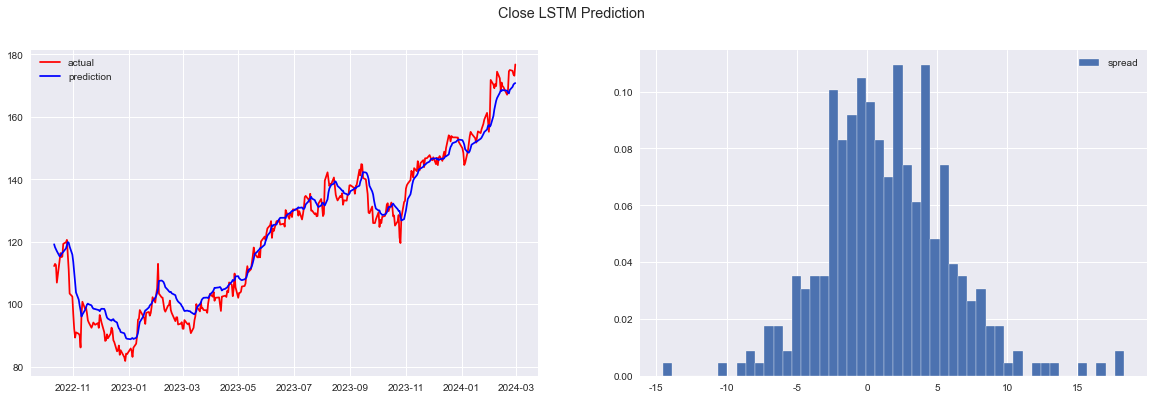

In [29]:
y_pred = model.predict(X_test)
df = pd.DataFrame({
    'actual': y_scaler.inverse_transform(y_test).flatten(),
    'prediction': y_scaler.inverse_transform(y_pred).flatten()}, 
    index = test_data[lookback:].index)

df['spread'] = df['prediction'] - df['actual']

print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('Close LSTM Prediction')
plt.show()

### BackTesting

In [18]:
from backtesting import Backtest, Strategy
from backtesting import Strategy
import pandas as pd

def RETURN(pred,actual):
    """
    the predicted returns
    """
    return (pd.Series(pred)/pd.Series(actual).shift(1) - 1).fillna(0)

class BuyHoldSell(Strategy):

    def init(self):
        self.returns = self.I(RETURN, self.data.prediction,self.data.actual)
        self.hold = False
        self.benchmark = 0.05
    
    def next(self):

        if self.returns > self.benchmark and self.hold == False:
            self.position.close()
            self.buy()
            self.hold = True

        elif self.returns < -1.0* self.benchmark  and self.hold == True:
            self.position.close()
            self.sell()
            hold = False

df['return'] = df['prediction'].shift(-1)/df['actual'] - 1
df_backtest = pd.concat([df,data.loc[df.index,:]],axis=1)
df_backtest.head(10)

Loading BokehJS ...

,actual,prediction,spread,return,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,
2022-10-11,112.209999,119.762749,7.552750,0.058660,112.709999,115.480003,110.389999,112.209999,112.209999,56432200
2022-10-12,112.900002,118.792229,5.892227,0.046597,112.489998,113.830002,111.400002,112.900002,112.900002,45728700
2022-10-13,112.529999,118.160812,5.630814,0.044854,107.879997,113.440002,105.349998,112.529999,112.529999,86868100
2022-10-14,106.900002,117.577370,10.677368,0.084338,114.099998,114.959999,106.599998,106.900002,106.900002,67737300
2022-10-17,113.790001,115.915756,2.125755,0.020226,110.110001,114.190002,110.089996,113.790001,113.790001,62782000
2022-10-18,116.360001,116.091545,-0.268456,0.003659,119.059998,119.519997,114.790001,116.360001,116.360001,65607400
2022-10-19,115.070000,116.785767,1.715767,0.017620,114.709999,116.589996,113.220001,115.070000,115.070000,47198100
2022-10-20,115.250000,117.097504,1.847504,0.018792,113.830002,118.239998,113.510002,115.250000,115.250000,48795100
2022-10-21,119.320000,117.415756,-1.904243,-0.006391,114.790001,119.589996,114.500000,119.320000,119.320000,55660500


In [19]:
from backtesting import Backtest
bt = Backtest(df_backtest,  
                BuyHoldSell, 
              cash=10_000, 
              commission=.002
             )
stats = bt.run()
print('Backtest:\n',stats)

Backtest:
 Start                     2022-10-11 00:00:00
End                       2024-02-29 00:00:00
Duration                    506 days 00:00:00
Exposure Time [%]                   99.425287
Equity Final [$]                 15274.862966
Equity Peak [$]                  15861.710109
Return [%]                           52.74863
Buy & Hold Return [%]               57.526064
Return (Ann.) [%]                   35.901721
Volatility (Ann.) [%]               50.558493
Sharpe Ratio                         0.710103
Sortino Ratio                        1.550088
Calmar Ratio                         1.122044
Max. Drawdown [%]                  -31.996727
Avg. Drawdown [%]                   -4.437991
Max. Drawdown Duration      217 days 00:00:00
Avg. Drawdown Duration       20 days 00:00:00
# Trades                                    2
Win Rate [%]                             50.0
Best Trade [%]                      56.703652
Worst Trade [%]                     -2.341761
Avg. Trade [%]         

In [20]:
bt.plot()

Row(id='1476', ...)